In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras import (
    models,
    layers,
    optimizers,                                                                 #### IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS PARA CRIAÇÃO DO MODELO.
    losses,                                                                     #### TENSORFLOW/KERAS IMPORTOU OS DADOS/FUNÇÕES DE PERDA/METRICAS/CALLBACKS (ALGO NOVO PRA MIM)
    metrics                                                                     #### IMPORTOU TBM NUMPY PRA CALCULOS MATEMATICOS/MATRIZ, MATPLOTLIB E SEABORN PRA PLOT DE GRÁFICOS
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# configs >>>                                                                   CONFIGURAÇÕES GERAIS DO MODELO!
h={
    "MAX_WORD_INDEX" : 10000,
    "VAL_PERC" : 0.1,
    "EMBEDDING_DIM" : 32,
    "NUM_LSTM_UNITS" : 32,
    "LR" : 0.001,
    "BETA1" : 0.9,
    "BETA2" : 0.999,
    "EPSILON" : 1.0e-8,
    "DECAY" : 0.0,
    "NUM_EPOCHS" : 30,
    "BATCH_SIZE" : 32
    }

In [5]:
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=h['MAX_WORD_INDEX']) # CARREGANDO OS DADOS EM DOIS CONJUNTOS TREINO/TEST E LIMITANDO
# O NUMERO MÁXIMO DE PALAVRAS A 10 MIL PALAVRAS COM BASE NO ARQUIVO DE CONFIGURAÇÃO

# PS: CHEQUEI A DOCUMENTAÇÃO E ELE FALA QUE AS PALAVRAS SÃO RANQUEDAS (SORT) DE ACORDO COM A FREQUENCIA QUE ELAS OCORREM. OU SEJA, APENAS AS PALAVRAS MAIS FREQUENTES SÃO
# MANTIDAS.AS PALAVRAS MENOS FREQUENTES VÃO APARECER OVV_CHAR (ACREDITO QUE SEJA O QUE O PROFESSOR COMENTOU DE NAN OR ??? ALGO DO TIPO)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
max_seq_len_train = max([len(sequence) for sequence in train_data])

max_seq_len_test = max([len(sequence) for sequence in test_data])
                                                                                # VISUALIZANDO O COMPRIMENTO DO MAIOR E DO MENOR COMENTÁRIO EM CADA DATASET
min_seq_len_train = min([len(sequence) for sequence in train_data])

min_seq_len_test = min([len(sequence) for sequence in test_data])

print(max_seq_len_train,'\n',max_seq_len_test,'\n',min_seq_len_train,'\n',min_seq_len_test)

2494 
 2315 
 11 
 7


In [7]:
# prompt: see shape of all dataset >>> USEI A IA DO PROPRIO GOOGLE DRIVE PRA GERAR ESSES PRINTS

print("Train data shape:", train_data.shape)                                    # VISUALIZAÇÃO DO COMPRIMENTO DE CADA DATASET. AQUI SÃO TODOS 1D
print("Train labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (25000,)
Train labels shape: (25000,)
Test data shape: (25000,)
Test labels shape: (25000,)


In [8]:
word_index = imdb.get_word_index() # CHEQUEI NA DOCUMENTAÇÃO >>> RETORNA UM DICIONÁRIO DE PALAVRAS MAPEADO COM SEUS RESPECTIVOS ÍNDICES.
# ACREDITO QUE ISSO SEJA POR EXEMPLO, PALAVRA 0: FRENCH, PALAVRA 1: HORROR... PALAVRA 2000: HORROR (PORTANTO PALAVRA 1) E ASSIM SUCESSIVAMENTE

ind = 10 # DECODIFICANDO A DÉCIMA SEQUENCIA DO CONJUNTO DE TREINAMENTO (SÓ PRA VISUALIZAR QUAL É O COMENTÁRIO)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # SÓ INVERTENDO O DICIONÁRIO. POR EXEMPLO:
'''DICT_NORMAL = {
    'a': 1,
    'b': 2,
    'c': 3
}
DICT_INVERTED = {
    1: 'a',
    2: 'b',
    3: 'c'
}
'''
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[ind]]) ### PRA CADA STRING NO CONJUNTO DE TREINAMENTO ELE ADICIONA UM ESPAÇO. O QUE
# EU ACREDITO QUE TENHA SIDO FEITO AQUI FOI PQ COMO DECODED VEM COMO LISTA, CADA INDICE SERIA POR EXEMPLO ['PALAVRA_1','PALAVRA_2'...] ELE FEZ ESSE JOIN AQUI COM ' '
# PRA SAIR FICAR MAIS AMIGAVEL DE SE VISUALIZAR. POR EXEMPLO: PALAVRA_1 PALAVRA_2 PALAVRA_3...

print(decoded_review)
print(train_data[ind])
print(train_labels[ind])


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance ? on to the scene ? ? the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made ? was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is ? by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named ? sent to prison for fraud he is put in a cell with three others the quietly insane ? body building ? marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old ? after ? part of it they soon realise its magical powers and realise they may be able to use it t

In [9]:
# preprocessing -> we need to do padding

X_train = keras.preprocessing.sequence.pad_sequences(train_data)                # USANDO UMA FUNÇÃO DO PROPRIO KERAS PRA ADICIONAR O PADDING NA MATRIZ
X_test = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=X_train.shape[1]) ### ISSO AQUI É PQ O COMPRIMENTO DO MAIOR COMENTÁRIO (2494) FICOU NO CONJ DE TREINAMENTO.
# QUANDO A GNT DIVIDIU OS CONJUNTOS, FEZ COM Q O CONJ DE TEST TIVESSE UM 'NOVO' COMENTÁRIO COM MAIOR COMPRIMENTO. AGORA A GNT SÓ ADICIONOU O PADDING PRA ELE FICAR TBM COM 2494
'''
EXEMPLO DO QUE FOI FEITO AQUI:
MATRIZ_ORIGINAL =
        [
    [1],
    [2,2],
    [3,3,3]
    ]
MATRIZ_PAD =
        [
    [0,0,1],
    [0,2,2],
    [3,3,3]
    ]
]

'''

print(X_train.shape)
print(X_test.shape)



(25000, 2494)
(25000, 2494)


In [10]:
y_train = np.array(train_labels).astype('float32')
print(y_train.shape)                                            ##### SÓ CONVERTENDO PRA FLOAT32 PRA OCUPAR MENOS MEMORIA
y_test = np.array(test_labels).astype('float32')
print(y_test.shape)


(25000,)
(25000,)


In [11]:
from sklearn.model_selection import train_test_split ### DIVIDINDO O CONJUNTO DE TREINAMENTO EM TREINO E VALIDAÇÃO PRA EVITAR MEMORIZAÇÃO DOS DADOS E POSSIVEL
# OVERFITTING

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=h['VAL_PERC'], stratify=y_train) # UTILIZAMOS ESSA FUNÇÃO AQUI PQ INICIALMENTE
# IRIAMOS DIVIDIR O 10% (VAL_PERC), OU SEJA, OS 10% ULTIMOS SERIAM PRA VALIDAÇÃO E OS 90% INICIAIS, PRA TREINO. NO ENTANTO, UTILIZANDO O TRAIN_TEST_SPLIT, A GNT GARANTE
# OS 10%, COM O PARAMETRO TEST_SIZE, MAS MELHOR AINDA, UTILIZANDO O STRATIFY, GARANTIMOS UMA DISTRIBUIÇÃO DOS DADOS EQUALITÁRIA TANTO PRA UM QUANTO PRA OUTRO (CLASSES
# COM AS MESMAS PROPORÇÕES EM CADA CONJUNTO)

print(X_train_final.shape)
print(X_val.shape)
                                                                                ### VISUALIZAÇÃO DO TAMANHO DE CADA CONJUNTO
print(y_train_final.shape)
print(y_val.shape)
print(X_val.shape)

print(y_train_final.shape)
print(y_val.shape)

(22500, 2494)
(2500, 2494)
(22500,)
(2500,)
(2500, 2494)
(22500,)
(2500,)


In [12]:
model1 = models.Sequential([
    layers.Embedding(h['MAX_WORD_INDEX'], h['EMBEDDING_DIM']),    # INSTANCIANDO O MODELO DE LSTM UTILIZANDO O EMBEDDING E UM CAMADA DENSA.
    layers.LSTM(h['NUM_LSTM_UNITS']),
    layers.Dense(1, activation='sigmoid')
])
model1.summary() #### RESUMO DO FLUXO DE CAMADAS Q O MODELO IRÁ SEGUIR.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
model1.compile(
    optimizer=optimizers.Adam( # OTIMIZADOR ADAM
        learning_rate=h['LR'], # LEARNING RATE
        beta_1=h['BETA1'],
        beta_2=h['BETA2'],
        epsilon=h['EPSILON'], ############### COMPILANDO O MODELO COM AS VARIAVEIS DE CONFIGURAÇÕES SETADAS NO INICIO DO NOTEBOOK
        decay=h['DECAY']
    ),
    loss=losses.binary_crossentropy, ###### FUNÇÃO PERDA PRA CLASSIFICAÇÃO BINÁRIA
    metrics=[metrics.binary_accuracy] ###### MÉTRICA USADA PARA AVALIAR O MODELO DURANTE O TREINAMENTO
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [14]:
callback_list = [ ###### ISSO AQUI É NOVO PRA MIM. PELO O QUE O PROFESSOR EXPLICOU EM SALA, É COMO SE FOSSE ALGO RELACIONADO A PARAR O TREINAMENTO DO MODELO QUANDO
    EarlyStopping(monitor='binary_accuracy', mode='max', patience=5) #      AS MÉTRICAS NÃO ESTIVEREM AUMENTANDO TANTO EM COMPARAÇÃO COM AS EPOCAS 'ANTERIORES'. POR EXEMPLO
    ] ########## EPOCH 19 ACURACIA 0.990 EPOCH 20 0.991 EPOCH 21 0.9911. PELO Q ENTENDI É ISSO

'''
DA DOCUMENTAÇÃO: A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

PELO Q ENTENDI É: AÇÕES Q ELE TOMA DURANTE O TREINAMENTO DO MODELO.
'''

In [15]:
history1 = model1.fit( ############# TREINAMENTO DO MODELO USANDO OS CONJS. TREINAMENTO/VALIDAÇÃO, COM AS CONFIGURAÇÕES DE BATCH E EPOCH SETADAS
    X_train_final, # NO INICIO DO NOTEBOOK, BEM COMO A LISTA DE CALLBACKS CITADOS ANTES E USANDO O PARAMETRO SHUFFLE PRA EMBARALHAR OS DADOS A CADA EPOCH
    y_train_final,
    epochs=h['NUM_EPOCHS'],
    batch_size=h['BATCH_SIZE'],
    validation_data=(X_val, y_val),
    callbacks=callback_list,
    shuffle=True
)

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - binary_accuracy: 0.7144 - loss: 0.5276 - val_binary_accuracy: 0.8568 - val_loss: 0.3488
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - binary_accuracy: 0.8992 - loss: 0.2647 - val_binary_accuracy: 0.8716 - val_loss: 0.3073
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - binary_accuracy: 0.9217 - loss: 0.2121 - val_binary_accuracy: 0.8712 - val_loss: 0.3444
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 85s 83ms/step - binary_accuracy: 0.9396 - loss: 0.1628 - val_binary_accuracy: 0.8800 - val_loss: 0.3383
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 76ms/step - binary_accuracy: 0.9574 - loss: 0.1239 - val_binary_accuracy: 0.8720 - val_loss: 0.3741
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - binary_accuracy: 0.9629 - loss: 0.1069 - val_binary_accuracy: 0.8724 - val_loss: 0.4550
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 85s 80ms/step - binary_accuracy: 0.9629 - loss: 0.1040 - val_binary_accuracy: 0.8680 - val_loss:

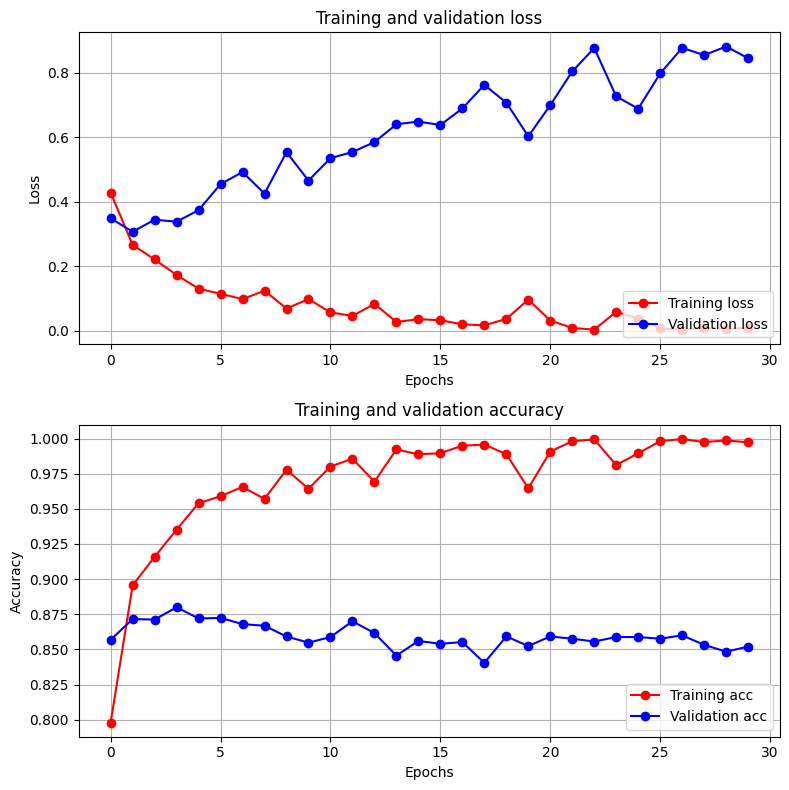

In [29]:
history_dict = history1.history # SÓ PRA PEGAR O DICIONARIO DAS METRICAS GERADAS DURANTE O TREINAMENTO

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']  ################# VISUALIZANDO O COMPORTAMENTO DO ERRO E DA ACURACIA TANTO NO CONJUNTO DE TREINAMENTO QUANTO NO CONJ
# DE VALIDAÇÃO DURANTE O TREINAMENTO DO MODELO

epochs = range(h['NUM_EPOCHS'])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(epochs, loss_values, 'o-r', label='Training loss')
ax1.plot(epochs, val_loss_values, 'o-b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='lower right')
ax1.grid()

ax2.plot(epochs, acc_values, 'o-r', label='Training acc')
ax2.plot(epochs, val_acc_values, 'o-b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
ax2.grid()

plt.tight_layout()
plt.show()


In [26]:
acc_values #######################  OLHAR PROXIMAS CELULAS. ANALISE DETALHADA

[0.7979555726051331,
 0.8955110907554626,
 0.9158666729927063,
 0.9351999759674072,
 0.9539555311203003,
 0.9590222239494324,
 0.9655555486679077,
 0.9570666551589966,
 0.9778666496276855,
 0.9642666578292847,
 0.9800888895988464,
 0.9856888651847839,
 0.9693333506584167,
 0.9922666549682617,
 0.9887999892234802,
 0.9896000027656555,
 0.9949333071708679,
 0.9956889152526855,
 0.9889333248138428,
 0.9645777940750122,
 0.9908000230789185,
 0.9981333613395691,
 0.9993777871131897,
 0.9811111092567444,
 0.9895555377006531,
 0.9980888962745667,
 0.9996888637542725,
 0.9974666833877563,
 0.998711109161377,
 0.9972888827323914]

In [33]:
max_value = np.array(acc_values) # convertendo a lista de acuracia pra array pra poder operar
max = max_value.max() # achando o valor maximo
positions = np.where(acc_values == max)[0] # condicional: onde, na lista de acuracia de treinamento, for igual a maximo valor, append em um array
print(positions,'\n') # posições onde ocorreu o maximo valor
print(max) # valor maximo de acuracia no treinamento

[26] 

0.9996888637542725


Aumentar o numero de epochs de 16 para 30 não significa necessariamente melhorar a performance do modelo. a gnt percebe pelo gráfico acima que, de fato, o erro no conjunto de treinamento abaixa a medida q aumenta o numero de epocas. no entanto, o erro para o conjunto de validação aumenta.

alem disso, pelo gráfico da acuracia, a gnt percebe o aumento da acuracia no conjunto de treinamento chegando até proximo de 1, na epoca 26

In [17]:
y_pred = model1.predict(X_test)         ##### FAZENDO PREDIÇÕES NO CONJUNTO DE TEST (CONJUNTO Q N FOI VISTO DURANTE O TREINAMENTO)
y_pred = (y_pred > 0.5).astype(int) ######### CONVERTENDO PRA UMA SAIDA DE 0 OU 1

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step


In [18]:
y_pred # VISUALIZANDO AS SAIDAS

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

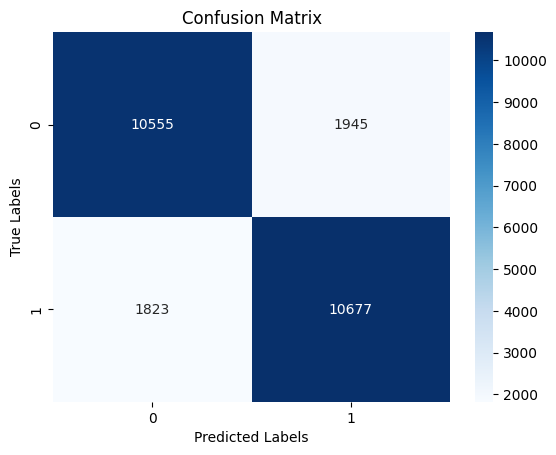

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') ##### AVALIAÇÃO DO MODELO POR MEIO DA MATRIZ DE CONFUSÃO TRUE VS PREDICTED
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()